# Going Beyond the SimpleImputer() For Missing Data Imputation
## Learn to leverage model-based imputation
![](./images/unsplash.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://unsplash.com/@alxznder?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Alexander Lam</a>
        on 
        <a href='https://unsplash.com/s/photos/missing?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Unsplash</a>
    </strong>
</figcaption>

### Setup

In [84]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

rcParams["figure.dpi"] = 300
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["font.size"] = 15
warnings.filterwarnings("ignore")

### Introduction

Despite the massive number of MOOCs and other online resources, there are still skill gaps in terms of dealing with certain data problems. One example is properly dealing with missing data in real-world datasets. Beginner learners might take this problem lightly and they are not to blame. Even though it is such a pressing issue, the complexity of data massingness problems has been greatly underestimated because of the availability of small, easy-to-work-with toy datasets. 

As a result, many beginner data scientists don't go beyond the simple techniques such as mean, median or mode imputation. Though these methods may suffice for simple datasets, they are in no way a competent solution to handling missing data with large datasets.

Like any other stage of data science workflow, missing data imputation is an iterative process. You should be able to use multiple methods and compare their results effectively. While the basic methods may end up performing well, it is rarely the case and you have to have a few backup strategies. 

This tutorial will introduce two more robust model-based imputation algorithms native to Sklearn - KNNImputer and IterativeImputer. Whereas for missing values in time-series data, you will learn about various interpolation techniques. Finally, we will see how to compare the results of different imputation techniques visually.

### Identifying the Type of Missingness

In [19]:
### HIDE
## Prep

diabetes = pd.read_csv("data/diabetes.csv")
to_encode = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
]
for col in to_encode:
    diabetes.loc[diabetes[col] == 0, col] = np.nan

The first step to implementing an effective strategy is to identify why the values are missing. Even though each case is unique, missingness can be grouped into 3 broad categories:

- **Missing Completely At Random (MCAR)**: this is a genuine case of data missing randomly. Sudden mistakes in data entry, temporary sensor failures, or generally missing data that is not associated with any factor. The amount of missingness is very low.
- **Missing At Random (MAR)**: this is a broader case of MCAR. Even though missing data may seem random at first glance, it will have some systematic relationship with the other observed factors. For example - data missing from observational equipment during the times of scheduled maintenance breaks. The key in this type of missingness is the systematic relationship between nulls and the other features in the dataset.
- **Missing Not At Random (MNAR)**: missing values may exist in large amounts and the reason for the missingness is associated with factors beyond our control or knowledge. 

> Identifying which category your problem falls into can help narrow down the set of solutions you can apply.

Let's further explore these missingness types using the [Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database):

```python
diabetes = pd.read_csv('data/diabetes.csv')
```

In [21]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [23]:
diabetes.isnull().mean().sort_values(ascending=False)

Insulin                     0.486979
SkinThickness               0.295573
BloodPressure               0.045573
BMI                         0.014323
Glucose                     0.006510
Outcome                     0.000000
Age                         0.000000
DiabetesPedigreeFunction    0.000000
Pregnancies                 0.000000
dtype: float64

There are 5 features with different proportions of missing values. One of the first things to do to identify the type is to plot a missingness matrix of null values. This special plot is available through the `missingno` package which we can import as `msno`:

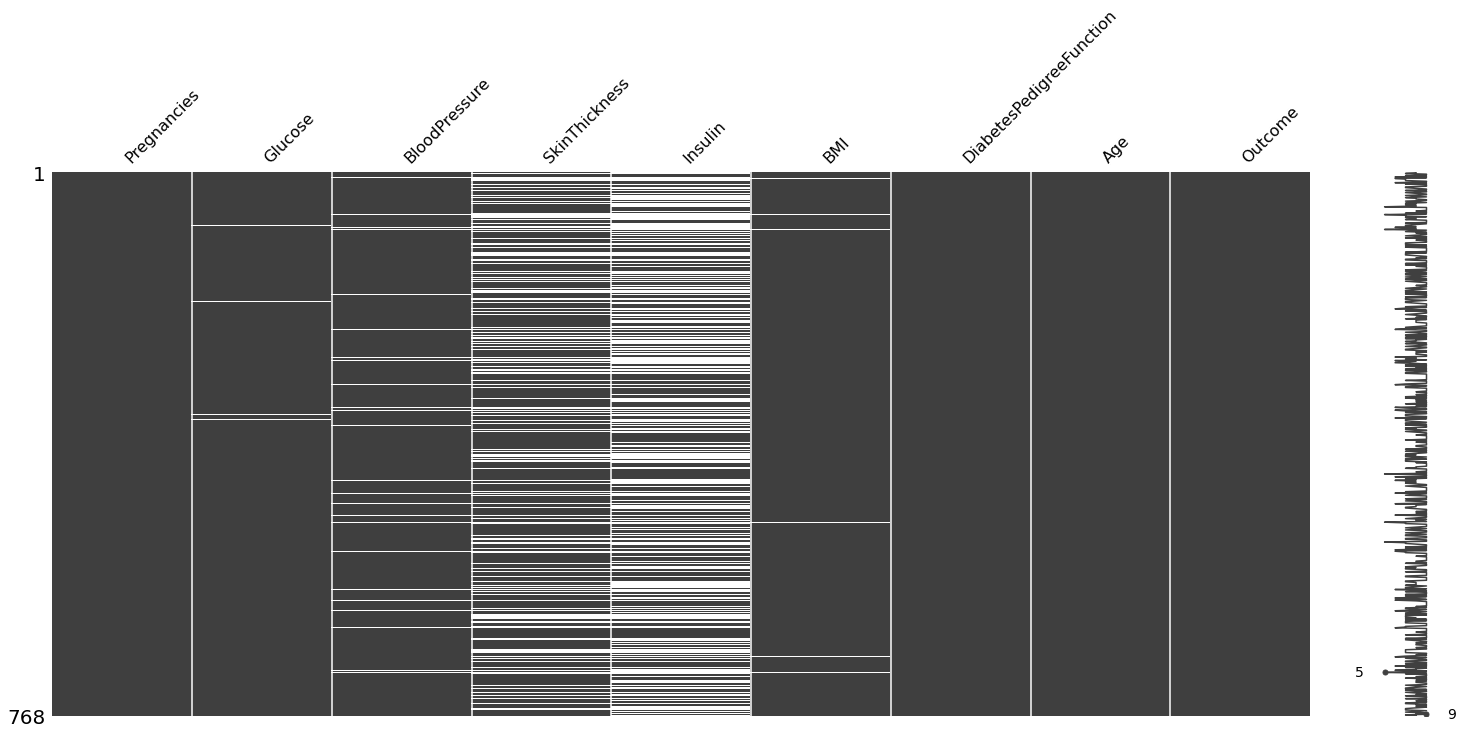

In [28]:
import missingno as msno  # # pip install missingno

# Plot correlation heatmap of missingness
msno.matrix(diabetes);

This matrix shows how nulls are scattered across the dataset. White segments or lines represent where missing values lie. The fact that the missing values in Glucose, BMI and Blood pressure columns are scattered randomly and their small proportions tells us that these values are simply missing completely at random. 

However, a large proportion of data points are missing in both Insulin and SkinFoldThickness features. So, is there some relationship between their missingness? 

To answer this, MSNO provides with a missingness heatmap which shows the correlation between values:

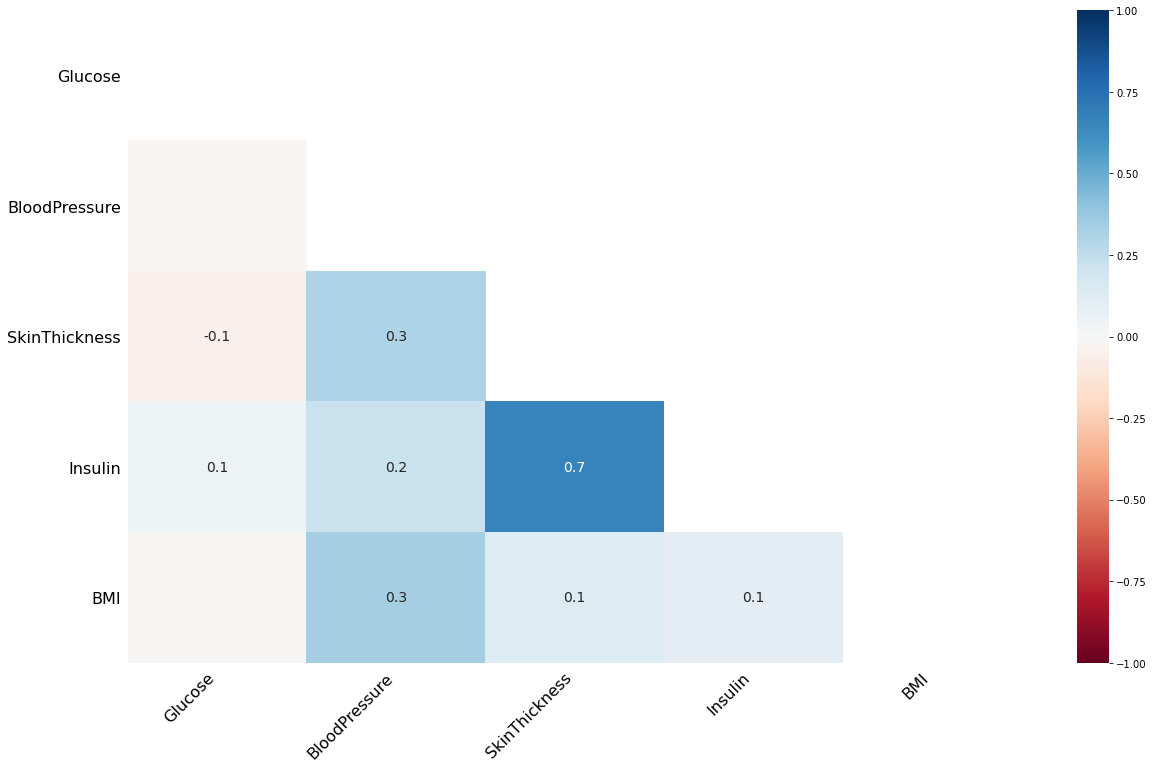

In [29]:
msno.heatmap(diabetes);

From the plot, we can see a strong correlation between Skin Thickness and Insulin. We can confirm this by also sorting though the values of either of them:

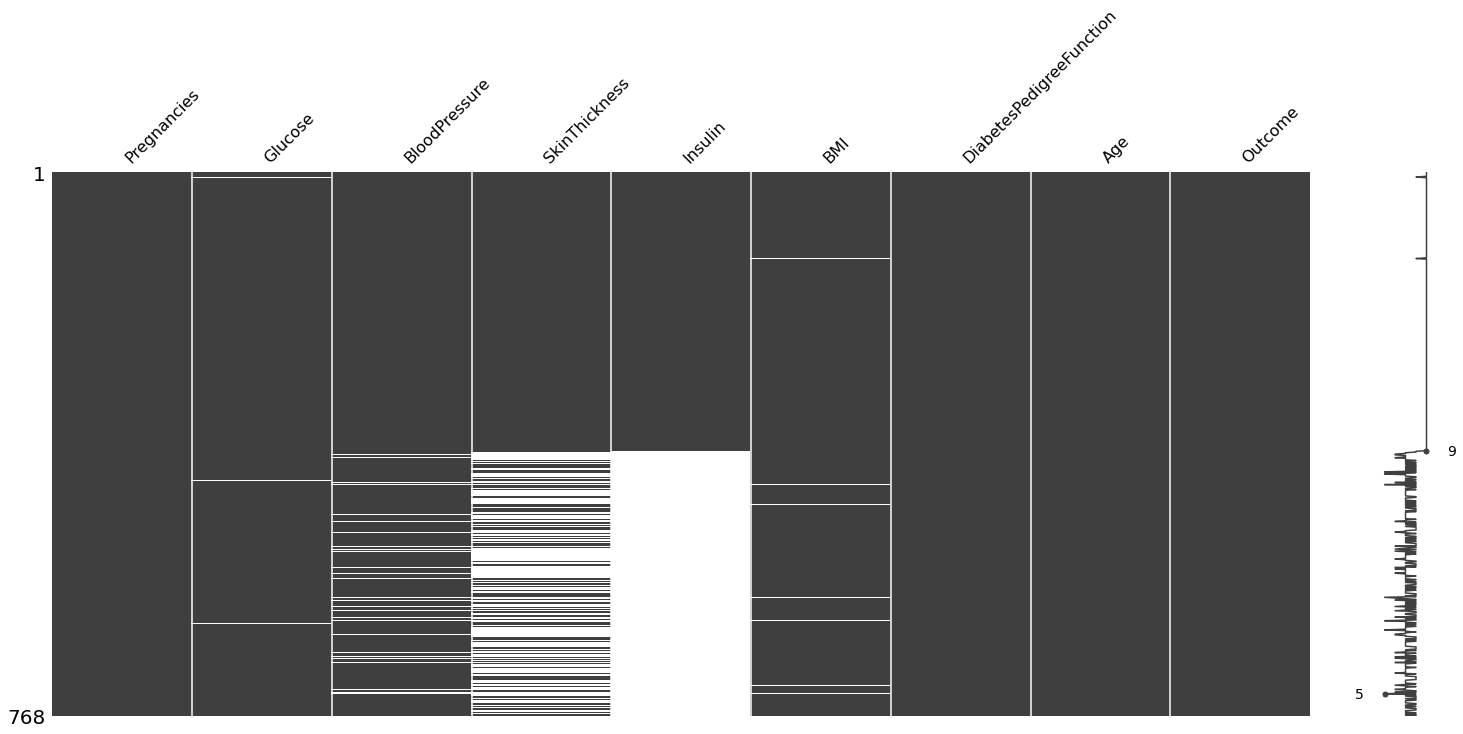

In [32]:
msno.matrix(diabetes.sort_values("Insulin"));

This plot confirms that we cannot not why values are missing in these two columns which can categorize as MNAR. We also saw a weak correlation between blood pressure and skin thickness which disproves our first assumption. Rather than being MCAR, blood pressure is missing at random (MAR).

These missingness categories can be a lot to wrap your mind around. For a deeper insight, you can refer to my other article specifically on missingness types and the MSNO package:

https://towardsdev.com/how-to-identify-missingness-types-with-missingno-61cfe0449ad9

Now, let's see how we can impute the nulls in the next sections.

### Imputing With KNNImputer

Apart from the `SimpleImputer`, Sklearn provides `KNNImputer` class which uses K-Nearest-Neighbors algorithm to impute numeric values. If you are not familiar with it, I recommend reading my separate article on it:

https://towardsdatascience.com/intro-to-scikit-learns-k-nearest-neighbors-classifier-and-regressor-4228d8d1cba6

For reference, here is an excerpt from the article briefly touching on how the algorithm works:

"Imagine you have a variable with 2 categories which are visualized here:

![](./images/1.png)
<figcaption style="text-align: center;">
    <strong>
        Image by Wikipedia
    </strong>
</figcaption>

Given a new, unknown sample, how do you tell which group it belongs to? Well, naturally, you would look at the surrounding points. But the result would be really dependent on how far you look. If you just look at the closest 3, (solid circle) the green dot would belong to red triangles. If you look further, (the dashed circle) dot would be classified as a blue square.

kNN works the same way. Depending on the value of k, the algorithm classifies new samples by the majority vote of the nearest k neighbors in classification. For regression which predicts the actual numerical value of a new sample, the algorithm just takes the mean of the nearest k neighbors.
"

KNNImputer is a slight modified version of the algorithm where it tries to predict the value of *numeric* nullity by averaging the distances between its *k* nearest neighbors. For folks who have been using Sklearn for a time, its syntax should not be a problem:

In [34]:
from sklearn.impute import KNNImputer

# Copy the data
diabetes_knn_imputed = diabetes.copy(deep=True)

# Init the transformer
knn_imp = KNNImputer(n_neighbors=3)

# Fit/transform
diabetes_knn_imputed.loc[:, :] = knn_imp.fit_transform(diabetes_knn_imputed)
diabetes_knn_imputed.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

With this imputer, the problem is choosing the right value for *k*. As you cannot use GridSearch to tune it, we can take a visual approach of comparison:

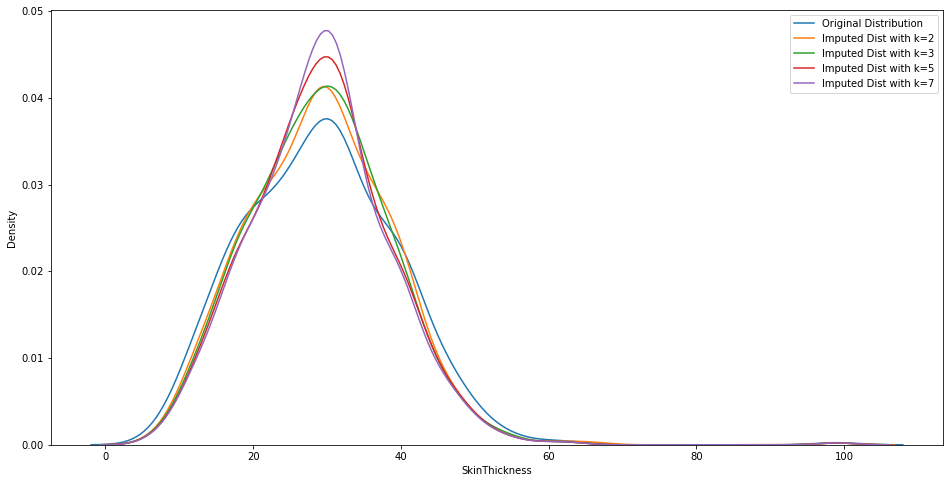

In [40]:
n_neighbors = [2, 3, 5, 7]

fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(diabetes.SkinThickness, label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    diabetes_knn_imputed.loc[:, :] = knn_imp.fit_transform(diabetes)
    sns.kdeplot(diabetes_knn_imputed.SkinThickness, label=f"Imputed Dist with k={k}")

plt.legend();

In the above plot, we are comparing the different KNN imputations for the SkinThickness feature using Probability Density plots. The closer the imputed distribution comes to the original, the better was the imputation. Here, it seems 2 neighbors is the best choice.

### Imputing With Iterative Imputer

Another more robust but more computationally expensive technique would be using `IterativeImputer`. It takes an arbitrary Sklearn estimator and tries to impute missing values by modeling other features as a function of features with missing values. Here is a more granular, step-by-step explanation of its functionality:

1. A regressor is passed to the transformer.
2. The first feature (*feature_1*) with missing values is chosen.
3. The data is split into train/test sets where train set contains all the known values for *feature_1* and test set contains the missing samples.
4. The regressor is fit on all the other variables as inputs with *feature_1* as an output. 
5. The regressor predicts the missing values.
6. Continues this process for all features with missing values are imputed.
7. Steps 1-6 are called a single iteration round. These steps are carried out multiple times as specified by the `max_iter` parameter of the transformer.

This means that `IterativeImputer` (II) predicts not one but *max_iter* number of possible values for a single missing sample. This has the benefit of treating each missing data point as a random variable and associate the inherent uncertainty that comes with missing values. This is also called **multiple imputation** and it is the base for the majority of other imputation techniques out there (yes, there are so many others). 

When all iterations are done, II returns only the last result of the predictions because through each iteration the predictions get better and better (like gradient descent). The algorithm also has an early stopping feature which can terminate the iterations if there aren't considerable difference between rounds.

According to Sklearn, this implementation of II was inspired by the more popular R MICE package (Multivariate Imputation by Chained Equations). Let's see it in action:

In [47]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Copy the data
diabetes_ii_imputed = diabetes.copy(deep=True)

# Init
ii_imp = IterativeImputer(
    estimator=ExtraTreesRegressor(), max_iter=10, random_state=1121218
)

# Tranform
diabetes_ii_imputed.loc[:, :] = ii_imp.fit_transform(diabetes_ii_imputed)

diabetes_ii_imputed.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

> `IterativeImputer` is still an experimental feature, so don't forget to include the first line of the above snippet.

When `estimator` is set to None, the algorithm chooses it on its own. But, after reading [this official guide](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py) on `IterativeImputer` by Sklearn, I learned that `BayesianRidge` and `ExtraTreeRegressor` yield the best results.

### Performance Comparison of the Different Techniques

It is time to test how well the imputations work. To accomplish this, we will be predicting if a patient has diabetes or not (*outcome*) feature, which is a binary classification task. Let's build feature/target arrays and divide data into train/test sets before the imputations:

In [50]:
from sklearn.model_selection import train_test_split

# Feature/target arrays
X_full = diabetes.drop("Outcome", axis=1).copy()
y_full = diabetes["Outcome"].values.reshape(-1, 1)

We will test both `KNNImputer` and `IterativeImputer` using cross-validation. For the estimators, we will use the recommended `BayesianRidge` and `ExtraTreeRegressor`:

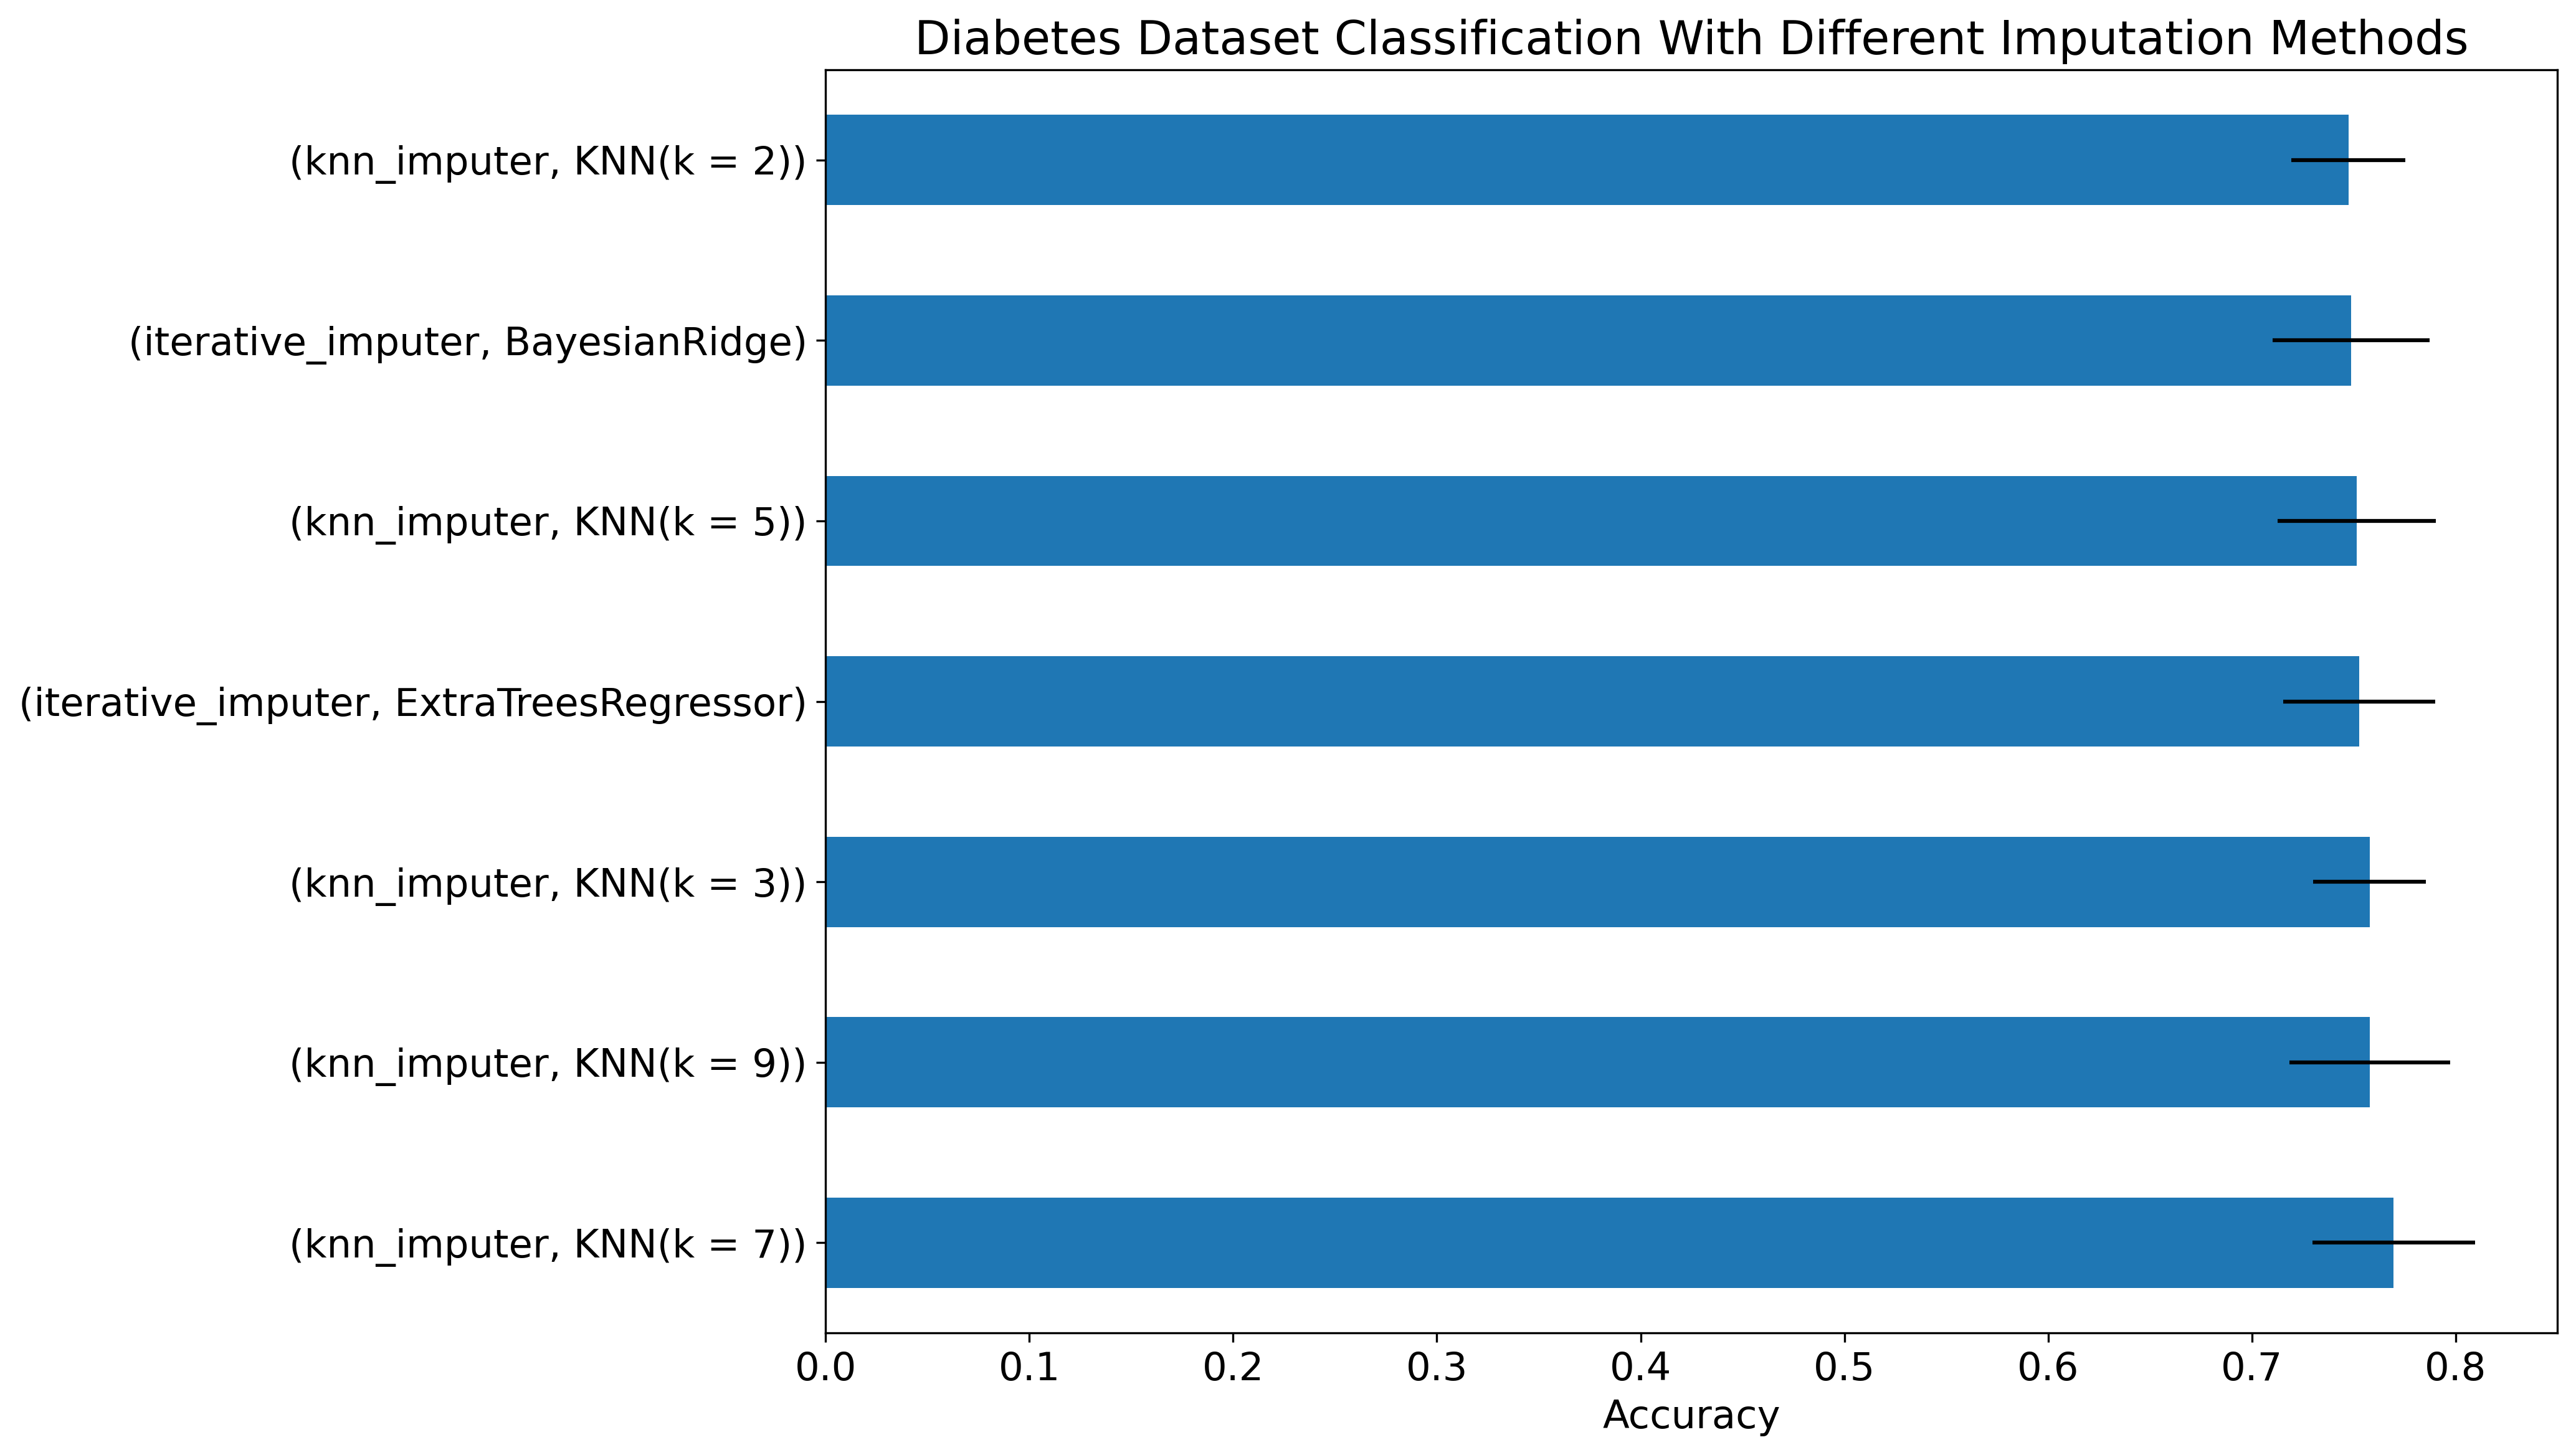

In [88]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Set global configs
cv = 5
scoring = "accuracy"
state = 1121218
forest = RandomForestClassifier()

# Store IterativeImputer scores
ii_scores = pd.DataFrame()
for estimator in [BayesianRidge(), ExtraTreesRegressor()]:
    pipe = make_pipeline(
        IterativeImputer(estimator=estimator, random_state=state), forest
    )
    ii_scores[estimator.__class__.__name__] = cross_val_score(
        pipe, X_full, y_full, scoring=scoring, cv=cv
    )

# Store KNN scores
knn_scores = pd.DataFrame()
n_neighbors = [2, 3, 5, 7, 9]
for k in n_neighbors:
    pipe = make_pipeline(KNNImputer(n_neighbors=k), forest)
    knn_scores[f"KNN(k = {k})"] = cross_val_score(
        pipe, X_full, y_full, scoring=scoring, cv=cv
    )

# Combines scores into a single DF
final_scores = pd.concat(
    [ii_scores, knn_scores],
    axis=1,
    keys=["iterative_imputer", "knn_imputer"],
)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

means, errors = final_scores.mean().sort_values(ascending=False), final_scores.std()
means.plot.barh(xerr=errors, ax=ax)

ax.set_title("Diabetes Dataset Classification With Different Imputation Methods")
ax.set_xlabel("Accuracy")
ax.set_yticks(np.arange(means.shape[0]))

plt.tight_layout(pad=1)
plt.show();

From the final results, we can see that KNNImputer with 7 neighbors is the best choice for the dataset when trained on RandomForests. Even though I mentioned that `IterativeImputer` would be more robust, you can never be sure. Maybe, we could have achieved better performance by tuning its parameters more.